# Exercise 4: Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural
networks and apply it to the task of hand-written digit recognition. Before
starting on the programming exercise, we strongly recommend watching the
video lectures and completing the review questions for the associated topics.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.io import loadmat
import utils

## 1. Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we
provided. In this exercise, you will implement the backpropagation algorithm
to learn the parameters for the neural network.

### 1.1 Visualizing the data

You will begin by visualizing a subset of the training set, using the function `displayData`, which is the same function we used in Exercise 3. It is provided in the `utils.py` file for this assignment as well. The dataset is also the same one you used in the previous exercise.

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

In [2]:
## load data
#  training data stored in arrays X, y
data = loadmat("./input/ex4data1.mat")
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

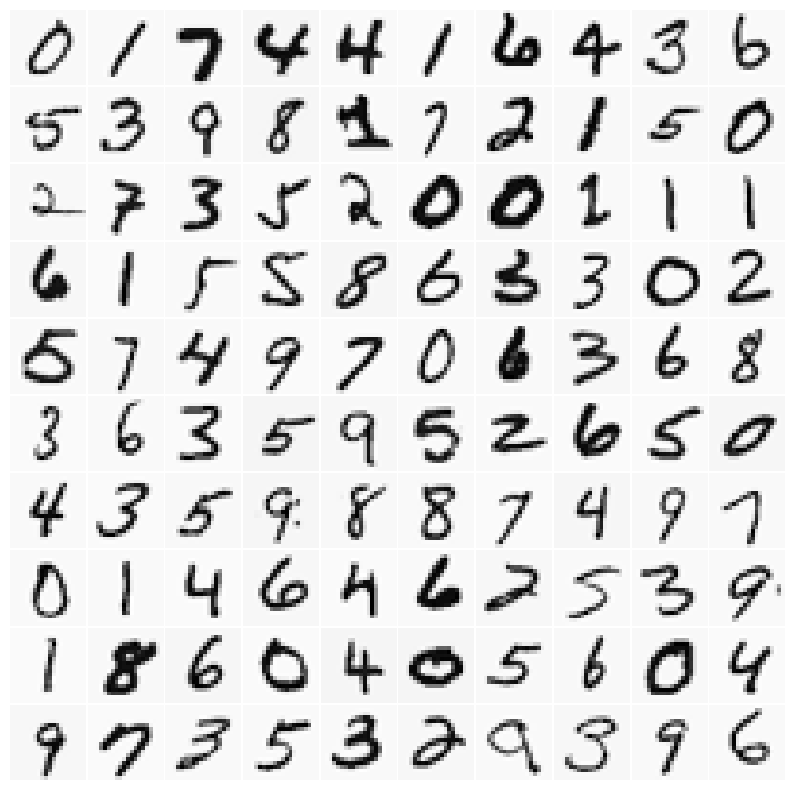

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.2 Model representation

Our neural network has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size `20 * 20`, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [4]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat("./input/ex4weights.mat")

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0) ## move the entire matrix down by 1 row
## bottom row goes to top

# Unroll parameters
## ?????
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

### 1.3 Feedforward and cost function

Cost function for neural network (without regularization):

$J(\theta)=\frac{1}{m}\Sigma^{m}_{i=1}\Sigma^{K}_{k=1}[-y^{(i)}_klog((h_{\theta}(x^{(i)}))_{k})-(1-y_k^{(i)})log(1-(h_{\theta}(x^{(i)}))_k)]$



In [56]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    
    Note 
    ----
    We have provided an implementation for the sigmoid function in the file 
    `utils.py` accompanying this assignment.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== EXAMPLE CODE ======================
#     X_ = X
#     X = np.concatenate([np.ones((m, 1)), X_], axis=1)# (5000, 400) ->  (5000, 401)
    
#     hidden_output_ = utils.sigmoid(X.dot(Theta1.T)) # (5000, 401) x (401, 25) -> (5000, 25)
#     hidden_output = np.concatenate([np.ones((m, 1)), hidden_output_], axis=1) # (5000, 25) ->  (5000, 26)
    
#     output = utils.sigmoid(hidden_output.dot(Theta2.T)) # (5000, 26) x (26, 10) -> (5000, 10)
    
#     expected = np.zeros(output.shape)
#     expected[np.arange(m), y] = 1
#     return expected, None
    # ====================== YOUR CODE HERE ======================
    X_ = np.insert(X, 0, 1, axis=1)
    h_x = utils.sigmoid(Theta2 @ np.insert(utils.sigmoid(Theta1@X_.T), 0, 1, axis=0))
    # print(h_x.shape)
    # return h_x, None
    y_ = np.zeros(h_x.shape)
    for i in range(h_x.shape[1]):
        y_[y[i], i] = 1
    # return y_.shape, None
    J = - (sum(sum(y_ * np.log(h_x))) + sum(sum((1 - y_) * np.log(1 - h_x)))) / m
    # J = y_.ravel() @ np.log(h_x.ravel()) + (1 - y_.ravel()) @ np.log(1 - h_x.ravel())
    
    
    
    # ================================================================
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

In [57]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)
# J[2300, :]
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


(5000, 400)